# Проект: промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

### Описание данных

Данные состоят из нескольких таблиц:
- data_arc — данные об электродах;
- data_bulk — данные об объёме сыпучих материалов;
- data_bulk_time — данные о времени подачи сыпучих материалов;
- data_gas — данные о продувке сплава газом;
- data_temp — данные об измерениях температуры;
- data_wire — данные об объёме проволочных материалов;
- data_wire_time — данные о времени подачи проволочных материалов.

Таблица ***steel.data_arc***

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

Таблица ***steel.data_bulk***

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

Таблица ***steel.data_bulk_time***

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

Таблица ***steel.data_gas***

- key — номер партии;
- gas — объём подаваемого газа.

Таблица ***steel.data_temp***

- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

Таблица ***steel.data_wire***

- key — номер партии;
- Wire1 … Wire9 — объём подаваемых проволочных материалов.

Таблица ***steel.data_wire_time***

-key — номер партии;
- Wire1 … Wire9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подключение библиотек

In [1]:
!pip install jinja2==3.1.2

  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.5
    Uninstalling Jinja2-3.1.5:
      Successfully uninstalled Jinja2-3.1.5


In [2]:
#!pip install -U pandas matplotlib seaborn sqlalchemy numpy scikit-learn catboost torch
#!pip install catboost==1.2.2
#!pip install torch==2.0.1

In [3]:
import os
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
RANDOM_STATE = 200225
pd.set_option('display.max_columns', None) 

## Загрузка данных

In [5]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [ ]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [7]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, engine)
print("Таблицы в базе данных:")
print(tables)

Таблицы в базе данных:
              name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


In [8]:
data_arc = pd.read_sql("SELECT * FROM data_arc", engine, parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk = pd.read_sql("SELECT * FROM data_bulk", engine)
data_bulk_time = pd.read_sql("SELECT * FROM data_bulk_time", engine, parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                                      'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11',
                                                      'Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
data_gas = pd.read_sql("SELECT * FROM data_gas", engine)
data_temp = pd.read_sql("SELECT * FROM data_temp", engine, parse_dates = ['Время замера'])
data_wire = pd.read_sql("SELECT * FROM data_wire", engine)
data_wire_time = pd.read_sql("SELECT * FROM data_wire_time", engine, parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])


In [9]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [10]:
def get_info (df):
    display(df.head(5))
    print('---------------------------------------------------------------------------------------------------------')
    display(df.info()) 
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество пропусков:  {df.isna().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Описание: ')
    display(df.describe())
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Размер: {df.shape}')

In [11]:
get_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


---------------------------------------------------------------------------------------------------------
Размер: (14876, 5)


In [12]:
get_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477
std,933.337642,18.277654,21.180578,75.483494,48.184126
min,1.000000,10.000000,228.000000,6.000000,12.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000


---------------------------------------------------------------------------------------------------------
Размер: (3129, 16)


In [13]:
get_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non

None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------------------------------------------------------------------------------
Размер: (3129, 16)


In [14]:
get_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key      0
Газ 1    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


---------------------------------------------------------------------------------------------------------
Размер: (3239, 2)


In [15]:
get_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 424.2+ KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key                0
Время замера       0
Температура     3427
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Время замера
count,18092.000000,18092
mean,1616.460977,2019-07-05 13:36:58.791620608
min,1.000000,2019-05-03 11:02:04
25%,807.750000,2019-06-04 00:35:01.249999872
50%,1618.000000,2019-07-03 02:11:48
75%,2429.000000,2019-08-07 23:10:05.249999872
max,3241.000000,2019-09-06 17:30:05
std,934.641385,NaN


---------------------------------------------------------------------------------------------------------
Размер: (18092, 3)


In [16]:
get_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Wire 1
count,3081.000000,3055.000000
mean,1623.426485,100.895853
std,932.996726,42.012518
min,1.000000,1.918800
25%,823.000000,72.115684
50%,1619.000000,100.158234
75%,2434.000000,126.060483
max,3241.000000,330.314424


---------------------------------------------------------------------------------------------------------
Размер: (3081, 10)


In [17]:
get_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------------------------------------------------------------------------------
Размер: (3081, 10)


**Вывод**
- `data_arc` Датасет включает 14876 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Пропусков и дубликатов не обнаружено. В столбце `key` указаны номера партий, и одной партии может соответствовать несколько наблюдений, судя по всему это количество повторений для очистки сплава для одной партии.
- `data_bulk` Датасет включает 3129 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Большинство объемов имеют не корректный тип данных `object`. Видим большое количество пропусков в объёмах подаваемого материала. Пропуск означает, что материал не добавляли в партию.
- `data_bulk_time` Датасет включает 3129 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Количество пропусков в данных о время подачи материала совпадает с количеством пропусков из предыдущего датасета.
- `data_gas` Датасет включает 3239 наблюдений. Название столбца не соответствует стандарту snake_case. Пропусков не обнаружено.
- `data_temp` Датасет включает 18092 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Столбец Температура имеет не корректный тип данных `object`, и в нем присутствуют пропуски.
- `data_wire` Датасет включает 3081 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Большинство столбцов имеют не корректный тип данных `object`. Во всех столбцах объёмов присутствуют пропуски.
- `data_wire_time` Датасет включает 3081 наблюдений. Названия столбцов не соответствуют стандарту snake_case. Во всех столбцах времени присутствуют пропуски.

## Исследовательский анализ и предобработка данных

### `data_arc`

Для начала приведем названия столбцов в стандартный вид.

In [18]:
data_arc.columns = ['key', 'begin_heat','end_heat', 'active_power', 'reactive_power']

In [19]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


У нас есть подозрительное минимальное значение реактивной мощности -715.479924. Посмотрим на графиг распределения и выбросы.


In [20]:
def hist_box(df,col):
    fig, axs = plt.subplots(ncols=2,figsize=(16,8))
    sns.set(font_scale=1.10)
    histplot = sns.histplot(df[col],ax=axs[0], color='green', bins=50).set_title(f'Распределение {col}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'Ящик с усами {col}',fontsize=20); 

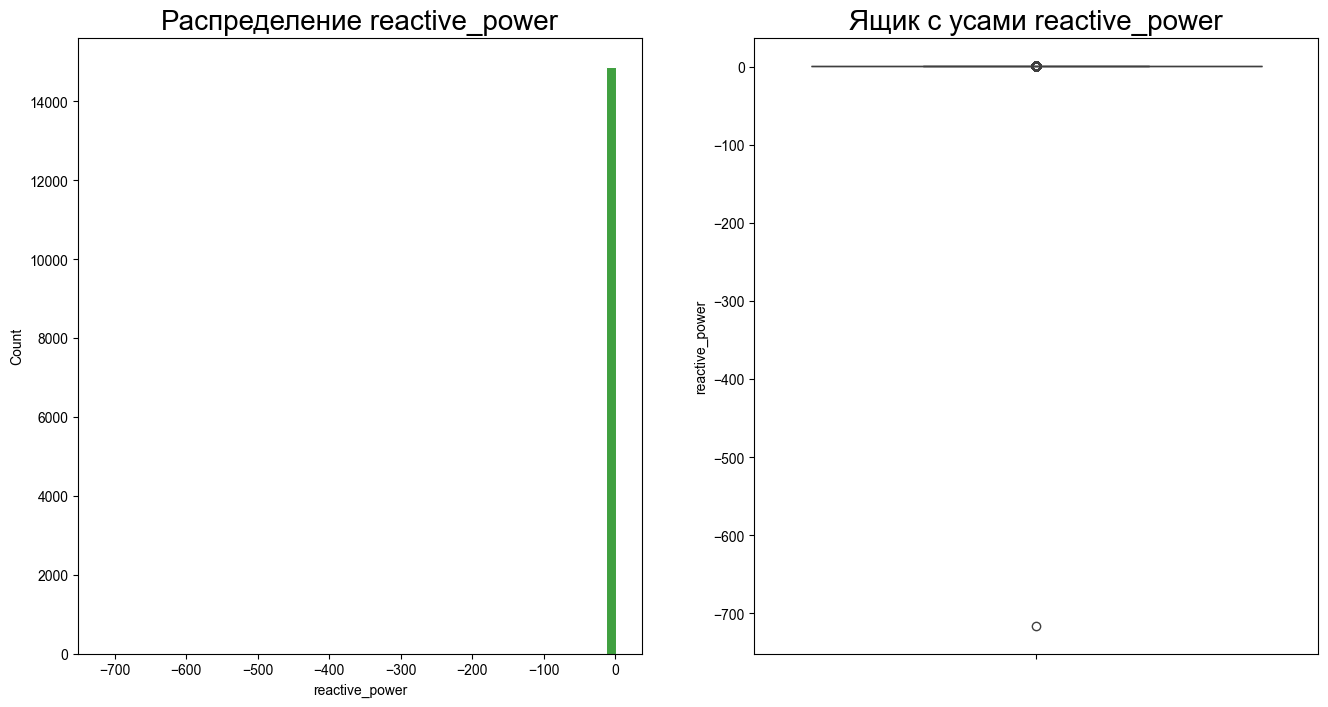

In [21]:
hist_box(data_arc,'reactive_power')

In [22]:
data_arc.query('reactive_power < 0')

,key,begin_heat,end_heat,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [23]:
data_arc.query('key == 2116')

,key,begin_heat,end_heat,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Это явно ошибка в данных. Удалим информацию о партию 2116.

In [24]:
data_arc = data_arc[~(data_arc['key'] == 2116)]

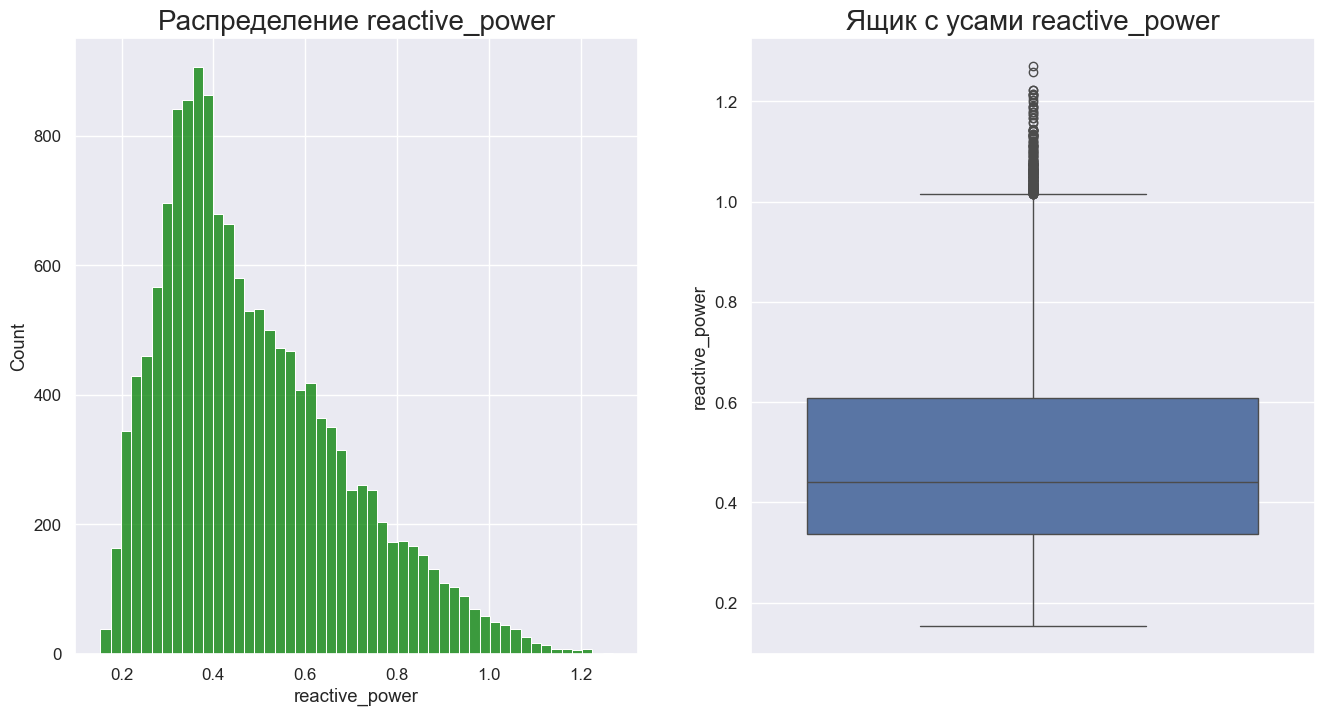

In [25]:
hist_box(data_arc,'reactive_power')

Теперь распределение выглядит нормально.

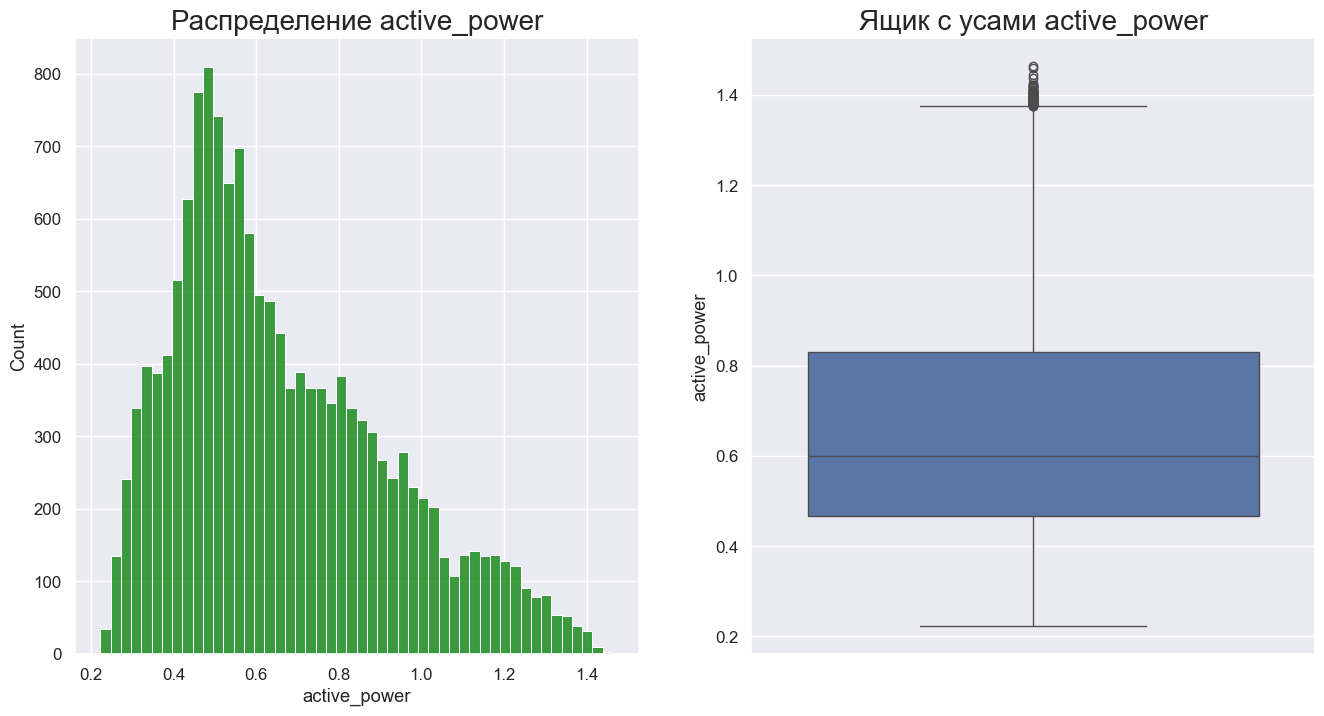

In [26]:
hist_box(data_arc,'active_power')

Проверим присутствуют ли данные, где время начала больше времени окончания.

In [27]:
data_arc.query('begin_heat > end_heat')

,key,begin_heat,end_heat,active_power,reactive_power


Будет целесообразно преобразовать признаки `begin_heat` и `end_heat` в один - `time_heat` - общее время нагрева.

In [28]:
data_arc['time_heat'] = (data_arc['end_heat'] - data_arc['begin_heat']).dt.total_seconds()

In [29]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [30]:
data_arc = data_arc.drop(['begin_heat', 'end_heat'], axis=1)

Рассчитаем полную мощность.

In [31]:
data_arc['power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

In [32]:
data_arc.head()

,key,active_power,reactive_power,time_heat,power
0,1,0.305130,0.211253,228.0,0.371123
1,1,0.765658,0.477438,185.0,0.902319
2,1,0.580313,0.430460,172.0,0.722536
3,1,0.518496,0.379979,365.0,0.642824
4,1,0.867133,0.643691,148.0,1.079934


Теперь имея полную мощность и общее время нагрева, рассчитаем энергию:

In [33]:
data_arc['energy'] = data_arc['power'] * data_arc['time_heat']

In [34]:
data_arc.head()

,key,active_power,reactive_power,time_heat,power,energy
0,1,0.305130,0.211253,228.0,0.371123,84.616003
1,1,0.765658,0.477438,185.0,0.902319,166.928978
2,1,0.580313,0.430460,172.0,0.722536,124.276277
3,1,0.518496,0.379979,365.0,0.642824,234.630603
4,1,0.867133,0.643691,148.0,1.079934,159.830252


Агрегируем значения признаков для каждой из партий.

In [35]:
data_arc = data_arc.groupby(by = 'key').sum().reset_index()

In [36]:
data_arc.head()

,key,active_power,reactive_power,time_heat,power,energy
0,1,3.036730,2.142821,1098.0,3.718736,770.282114
1,2,2.139408,1.453357,811.0,2.588349,481.760005
2,3,4.063641,2.937457,655.0,5.019223,722.837668
3,4,2.706489,2.056992,741.0,3.400038,683.455597
4,5,2.252950,1.687991,869.0,2.816980,512.169934


### `data_bulk`

Меняем тип данных.

In [37]:
for col in data_bulk.columns[1:]:
    data_bulk[col] = pd.to_numeric(data_bulk[col], errors='coerce')

In [38]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Приведем названия столбцов в стандартный вид.

In [39]:
data_bulk.columns = ['key',    'bulk_1', 'bulk_2',  'bulk_3',  'bulk_4',  'bulk_5',  'bulk_6',  'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [40]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Посмотрим, какие сыпучие материалы наиболее часто подаются в расплавленную сталь.

In [41]:
data_bulk_1 = data_bulk.drop('key', axis=1).notna().sum().reset_index()
data_bulk_1.columns = ['iteration', 'number']
data_bulk_1['percent'] = data_bulk_1['number'] / data_bulk.shape[0] 
data_bulk_1

,iteration,number,percent
0,bulk_1,252,0.080537
1,bulk_2,22,0.007031
2,bulk_3,1298,0.414829
3,bulk_4,1014,0.324065
4,bulk_5,77,0.024609
5,bulk_6,576,0.184084
6,bulk_7,25,0.007990
7,bulk_8,1,0.000320
8,bulk_9,19,0.006072
9,bulk_10,176,0.056248


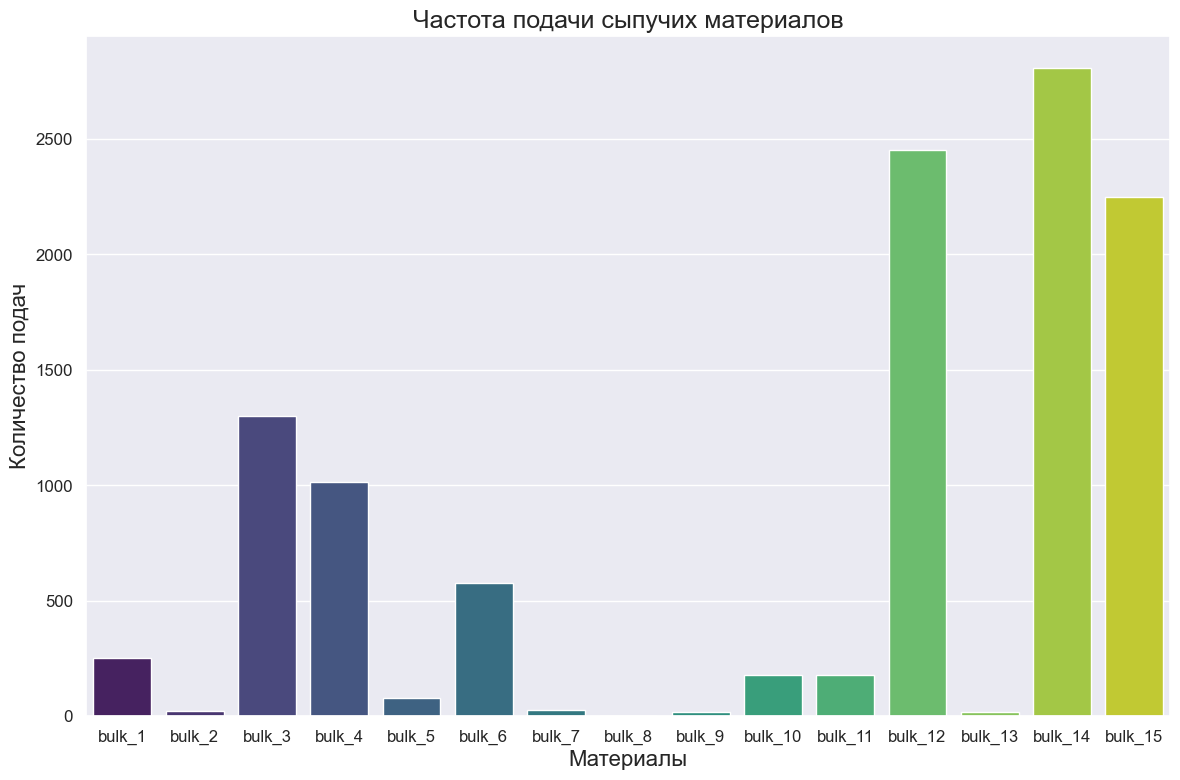

In [42]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data_bulk_1, 
    x='iteration', 
    y='number', 
    hue='iteration',
    palette='viridis', 
    estimator=sum, 
    legend=False
)
plt.title("Частота подачи сыпучих материалов", fontsize=18)
plt.xlabel("Материалы", fontsize=16)
plt.ylabel("Количество подач", fontsize=16)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

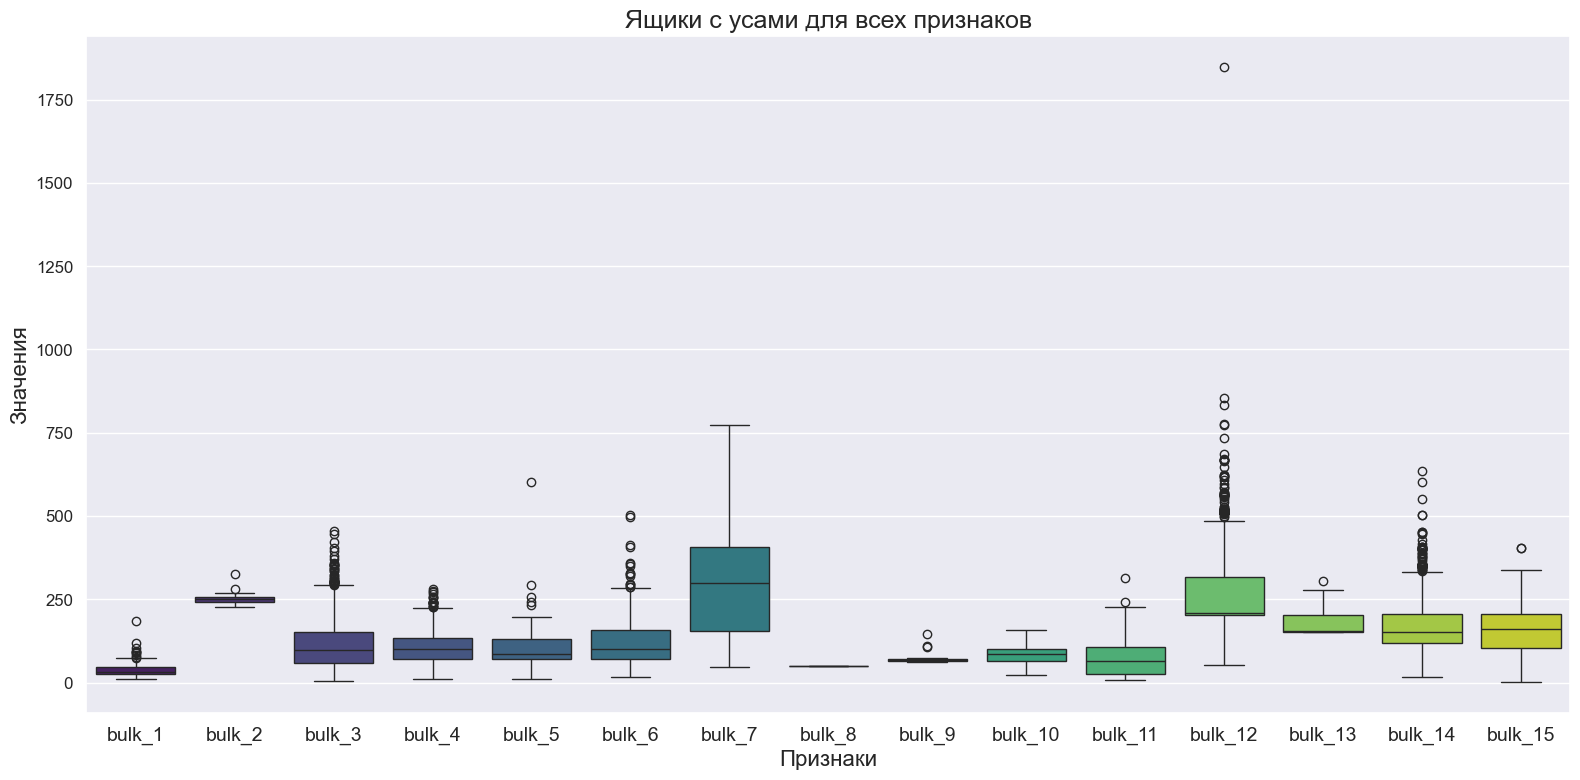

In [43]:
bulk_data = data_bulk.drop('key', axis=1)

plt.figure(figsize=(16, 8))  
sns.boxplot(data=bulk_data, palette='viridis')  

plt.title("Ящики с усами для всех признаков", fontsize=18)
plt.xlabel("Признаки", fontsize=16)
plt.ylabel("Значения", fontsize=16)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

У большинства признаков, за исключением `bulk_7` `bulk_8` `bulk_10`, присутствует значительное количество выбросов. Это может быть связано с редкими случаями подачи существенно больших объёмов материалов.

Посмотрим сколько процентов пропусков по каждому материалу.

In [44]:
pd.DataFrame(round(data_bulk.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
bulk_1,91.900000
bulk_2,99.300000
bulk_3,58.500000
bulk_4,67.600000
bulk_5,97.500000
bulk_6,81.600000
bulk_7,99.200000
bulk_8,100.000000
bulk_9,99.400000


Пропуск означает, что материал не добавляли в эту партию.
Заменим пропуски на 0.

In [45]:
data_bulk = data_bulk.fillna(0)

In [46]:
data_bulk.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

### `data_bulk_time`

In [47]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [48]:
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [49]:
pd.DataFrame(round(data_bulk_time.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
bulk_1,91.900000
bulk_2,99.300000
bulk_3,58.500000
bulk_4,67.600000
bulk_5,97.500000
bulk_6,81.600000
bulk_7,99.200000
bulk_8,100.000000
bulk_9,99.400000


`data_bulk_time` - это данные о времени, когда добавили сыпучий материал. Он тесно связан с датасетом `data_bulk` : пропуски там, где не добавляют сыпучий материал. 

### `data_gas`

Приведем названия столбцов в стандартный вид.

In [50]:
data_gas.columns = ['key', 'gas']


In [51]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


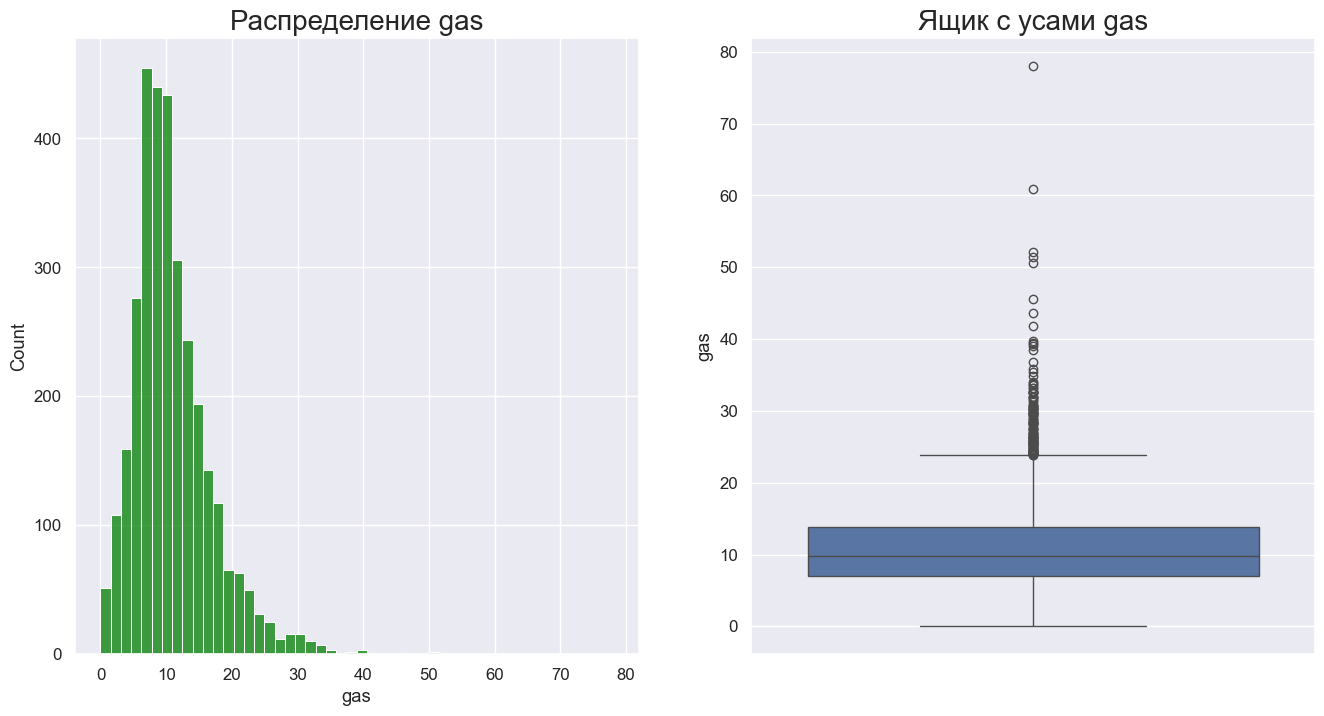

In [52]:
hist_box(data_gas,'gas')

Признак имеет нормальное распределение. Большинство партий продувались газом в объеме около 10 единиц.

### `data_temp`

Меняем тип данных.

In [53]:
data_temp["Температура"] = pd.to_numeric(data_temp["Температура"], errors="coerce")

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Приведем названия столбцов в стандартный вид.

In [55]:
data_temp.columns = ['key', 'mesaure_time', 'temperature']

In [56]:
data_temp.head()

,key,mesaure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Заказчик нас предупредил, что значения температуры ниже 1500 градусов — аномальные. Проверим их наличие.

In [57]:
data_temp.describe()

,key,mesaure_time,temperature
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


Минимальное значение температуры 1191 градус.

Поскольку целевой признак — это конечная температура партии, начальная температура может быть использована как входной признак. Наша задача — выявить аномальные значения температуры внутри партии. Если аномалии наблюдаются в начале партии, мы удалим всю партию целиком. Если же аномалии встречаются в промежуточных значениях, мы удалим только их.

In [58]:
data_temp.query('temperature < 1500')

,key,mesaure_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [59]:
for i in data_temp[data_temp['temperature'] < 1500]['key'].unique():
    display(data_temp[data_temp['key'] == i])

,key,mesaure_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


,key,mesaure_time,temperature
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0
6786,1214,2019-06-18 08:31:10,1608.0
6787,1214,2019-06-18 08:43:56,1591.0


,key,mesaure_time,temperature
9050,1619,2019-07-03 02:34:41,1218.0
9051,1619,2019-07-03 02:39:29,1623.0
9052,1619,2019-07-03 02:43:59,1590.0


,key,mesaure_time,temperature
11495,2052,2019-07-25 08:49:15,1227.0
11496,2052,2019-07-25 08:54:39,1592.0
11497,2052,2019-07-25 09:03:59,1590.0
11498,2052,2019-07-25 09:07:19,1591.0
11499,2052,2019-07-25 09:20:11,1515.0
11500,2052,2019-07-25 09:27:03,1592.0


,key,mesaure_time,temperature
14283,2561,2019-08-12 18:49:29,1204.0
14284,2561,2019-08-12 18:59:23,NaN
14285,2561,2019-08-12 19:06:26,NaN
14286,2561,2019-08-12 19:11:13,NaN
14287,2561,2019-08-12 19:17:08,NaN
14288,2561,2019-08-12 19:21:45,NaN


Все значения встречаются в начале партии, значит эти партии нужно удалить.

In [60]:
keys_to_remove = data_temp[data_temp['temperature'] < 1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(keys_to_remove)]

In [61]:
data_temp.describe()

,key,mesaure_time,temperature
count,18065.000000,18065,14643.000000
mean,1616.423194,2019-07-05 13:33:55.619761920,1590.865055
min,1.000000,2019-05-03 11:02:04,1519.000000
25%,807.000000,2019-06-03 23:54:22,1580.000000
50%,1618.000000,2019-07-03 02:01:12,1590.000000
75%,2429.000000,2019-08-07 23:12:57,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.995317,NaN,19.122102


Количество замеров температуры должно быть не менее двух: первый и последний замеры температуры. Посмотрим есть ли наблюдения, не соответсвующие данному условию.

In [62]:
temp_counts = data_temp.groupby('key')['temperature'].count()
invalid_parties = temp_counts[temp_counts < 2].index

print(f"Количество партий с менее чем 2 замерами температуры: {len(invalid_parties)}")

Количество партий с менее чем 2 замерами температуры: 740


In [63]:
data_temp = data_temp[~data_temp['key'].isin(invalid_parties)]

In [64]:
temp_counts_after = data_temp.groupby('key')['temperature'].count()
invalid_parties_after = temp_counts_after[temp_counts_after < 2].index

print(f"Количество партий с менее чем 2 замерами после удаления: {len(invalid_parties_after)}")

Количество партий с менее чем 2 замерами после удаления: 0


In [65]:
data_temp.isna().sum()

key             0
mesaure_time    0
temperature     0
dtype: int64

Оставим только нужные нам начальную и конечную температуры.

In [66]:
data_temp = data_temp.sort_values(by=['key', 'mesaure_time']).reset_index(drop=True)
data_temp = data_temp.pivot_table(
    index='key', 
    values='temperature', 
    aggfunc=['first', 'last']
)

In [67]:
data_temp.columns = ['first_temperature', 'last_temperature']
data_temp = data_temp.reset_index()

In [68]:
data_temp.head()

,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


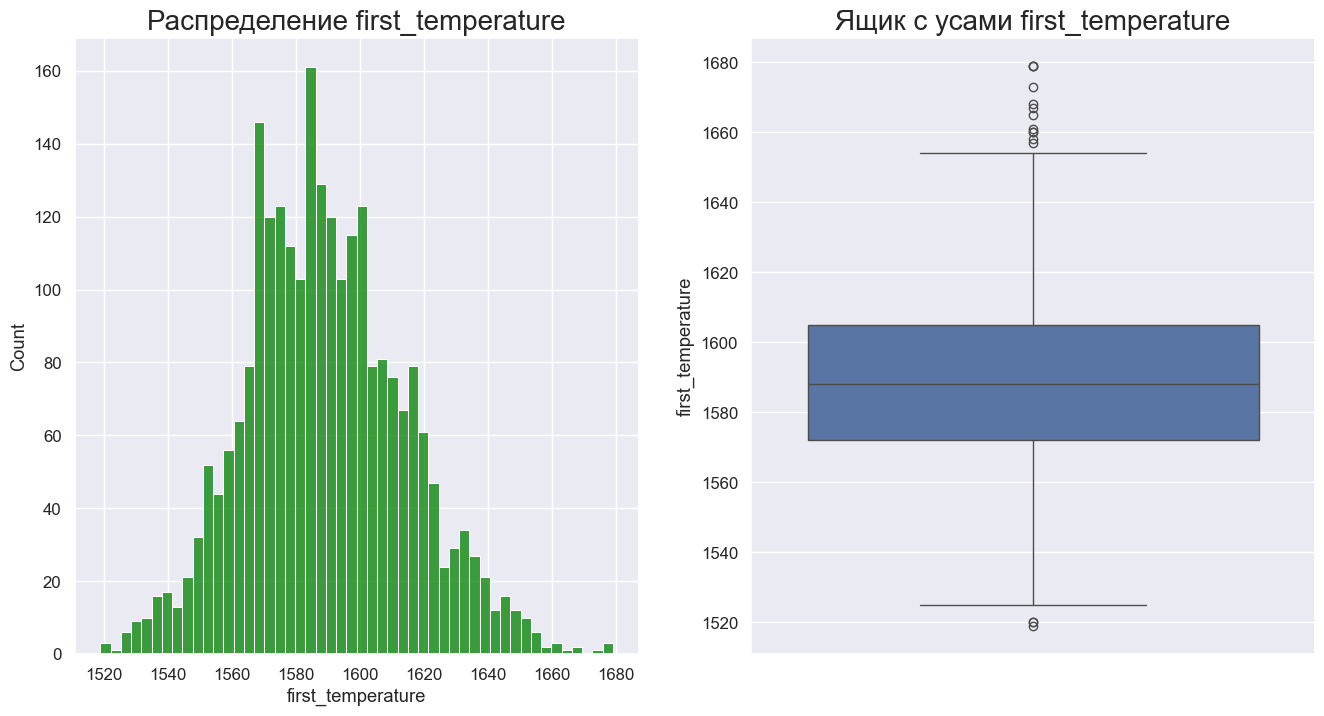

In [69]:
hist_box(data_temp,'first_temperature')

Признак имеет нормальное распределение. С незначительными выбросами.

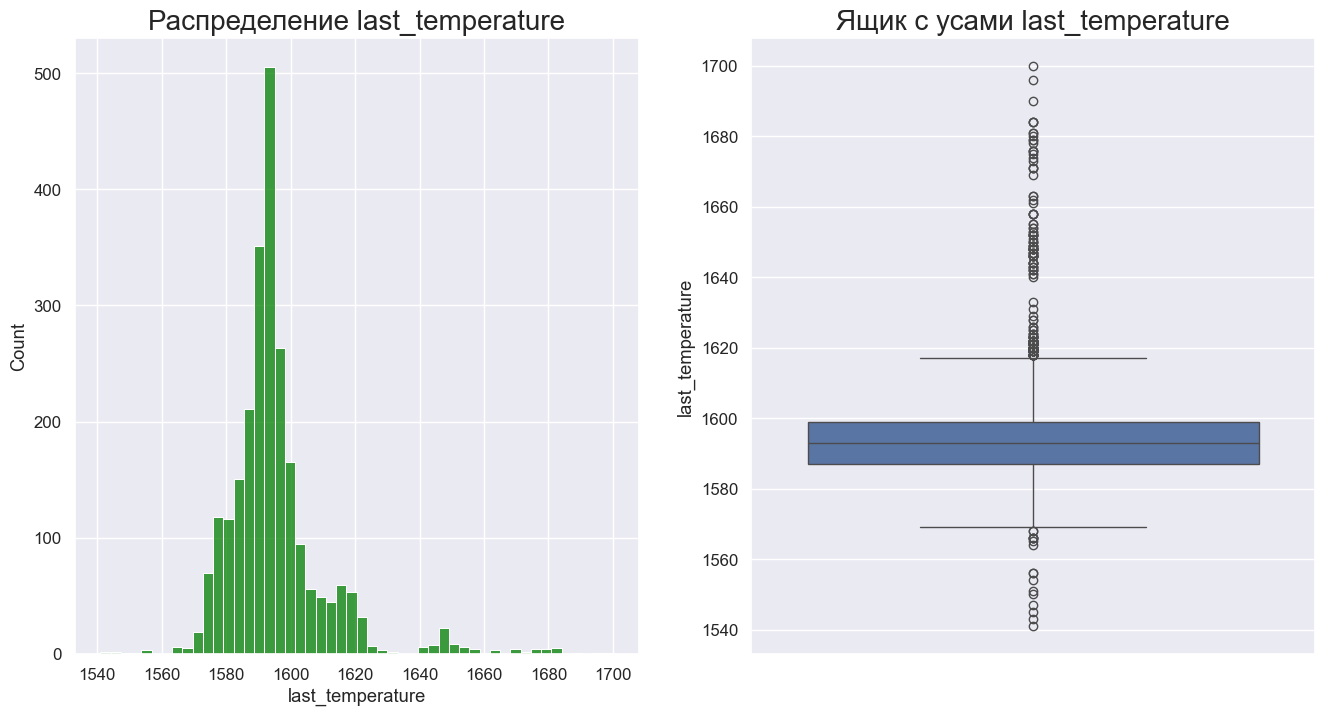

In [70]:
hist_box(data_temp,'last_temperature')

Признак имеет нормальное распределение. На гистограмме заметен небольшой "хвост" и перекос вправо, вызванный присутствием необычно высоких значений в диапазоне 1640-1700.

### `data_wire`

Меняем тип данных.

In [71]:
for col in data_wire.columns[1:]:
    data_wire[col] = pd.to_numeric(data_wire[col], errors='coerce')

In [72]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [73]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [74]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
pd.DataFrame(round(data_wire.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
wire_1,0.800000
wire_2,65.000000
wire_3,98.000000
wire_4,99.500000
wire_5,100.000000
wire_6,97.600000
wire_7,99.600000
wire_8,99.400000
wire_9,99.100000


Пропуск означает, что материал не добавляли в эту партию. Большинство партий используют только `wire_1`. Некоторые добавляют `wire_2`.

Заменим пропуски на 0 и удалим столбец wire_5.

In [76]:
data_wire.drop(['wire_5'], axis= 1 , inplace= True )

In [77]:
data_wire = data_wire.fillna(0)

In [78]:
data_wire.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

### `data_wire_time`

In [79]:
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [80]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [81]:
pd.DataFrame(round(data_wire_time.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
wire_1,0.800000
wire_2,65.000000
wire_3,98.000000
wire_4,99.500000
wire_5,100.000000
wire_6,97.600000
wire_7,99.600000
wire_8,99.400000
wire_9,99.100000


`data_wire_time` - это данные о времени, когда добавили проволочный материал. Он тесно связан с датасетом `data_wire` : пропуски там, где не добавляют проволочный материал.

Расчитаем длительность этапа легирования. Длительность этапа легирования отражает, как долго в партию добавляли материалы. Чем дольше этот этап, тем больше могло быть циклов обработки (нагрев, перемешивание), что влияет на температуру и энергозатраты. Это разница во времени между самой ранней и самой поздней подачей материалов для одной партии.
Для этого объединим таблицы с подаваемыми для легирования материалами.

In [82]:
data_time = data_bulk_time.merge(data_wire_time, on='key', how='inner')
print(data_time.shape)

(3025, 25)


In [83]:
data_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [84]:
time_cols = (['bulk_' + str(i) for i in range(1, 16)] + 
             ['wire_' + str(i) for i in range(1, 10)])

data_time['leg_min_time'] = data_time[time_cols].min(axis=1)
data_time['leg_max_time'] = data_time[time_cols].max(axis=1)
data_time['leg_duration_minutes'] = ((data_time['leg_max_time'] - data_time['leg_min_time']).dt.total_seconds() / 60).clip(lower=0)

print("Первые строки объединённой таблицы:")
print(data_time[['key', 'leg_min_time', 'leg_max_time', 'leg_duration_minutes']].head())
print("\nСтатистика по длительности легирования (в минутах):")
print(data_time['leg_duration_minutes'].describe())

Первые строки объединённой таблицы:
   key        leg_min_time        leg_max_time  leg_duration_minutes
0    1 2019-05-03 11:06:19 2019-05-03 11:28:48             22.483333
1    2 2019-05-03 11:36:50 2019-05-03 11:53:30             16.666667
2    3 2019-05-03 12:11:46 2019-05-03 12:32:39             20.883333
3    4 2019-05-03 12:43:22 2019-05-03 12:58:00             14.633333
4    5 2019-05-03 13:15:34 2019-05-03 13:34:12             18.633333

Статистика по длительности легирования (в минутах):
count    3025.000000
mean       25.808595
std        17.124350
min         0.000000
25%        16.183333
50%        23.150000
75%        32.050000
max       279.266667
Name: leg_duration_minutes, dtype: float64


In [85]:
data_time.query('leg_duration_minutes <= 0')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,leg_min_time,leg_max_time,leg_duration_minutes
46,49,NaT,NaT,NaT,NaT,NaT,2019-05-05 09:53:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-05 09:53:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-05 09:53:40,2019-05-05 09:53:40,0.0
93,112,NaT,NaT,2019-05-07 13:52:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-07 13:52:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-07 13:52:24,2019-05-07 13:52:24,0.0
218,246,NaT,NaT,2019-05-12 22:17:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-12 22:17:11,2019-05-12 22:17:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-12 22:17:11,2019-05-12 22:17:11,0.0
219,247,NaT,NaT,NaT,NaT,NaT,2019-05-12 23:19:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-12 23:19:20,2019-05-12 23:19:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-12 23:19:20,2019-05-12 23:19:20,0.0
220,248,NaT,NaT,NaT,2019-05-13 00:20:51,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-13 00:20:51,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-13 00:20:51,2019-05-13 00:20:51,0.0
250,279,NaT,NaT,NaT,NaT,NaT,2019-05-14 10:13:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-14 10:13:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-14 10:13:37,2019-05-14 10:13:37,0.0
487,530,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-23 14:54:17,NaT,2019-05-23 14:54:17,NaT,NaT,2019-05-23 14:54:17,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-23 14:54:17,2019-05-23 14:54:17,0.0
512,556,NaT,NaT,NaT,2019-05-24 17:35:03,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-24 17:35:03,2019-05-24 17:35:03,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-24 17:35:03,2019-05-24 17:35:03,0.0
569,614,NaT,NaT,NaT,2019-05-26 17:04:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-26 17:04:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-26 17:04:43,2019-05-26 17:04:43,0.0
679,732,NaT,NaT,2019-05-31 23:06:44,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-31 23:06:44,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-31 23:06:44,2019-05-31 23:06:44,0.0


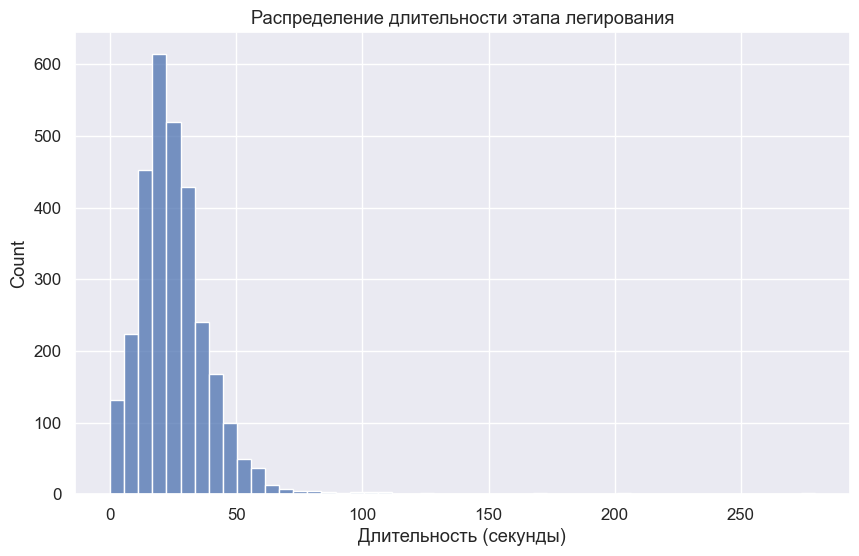

In [86]:
plt.figure(figsize=(10, 6))
sns.histplot(data_time['leg_duration_minutes'], bins=50)
plt.title('Распределение длительности этапа легирования')
plt.xlabel('Длительность (секунды)')
plt.show()

В 31 партиях все материалы (и сыпучие, и проволочные) добавлены одновременно (или записаны с одинаковой меткой времени). Это может быть особенностью процесса (например, одновременная подача через бункер и трайб-аппарат). Заказчик предупреждал об асинхронности датчиков. Возможно, в этих случаях время подачи округлилось или записалось некорректно, но это не считается ошибкой.

In [87]:
data_time = data_time[['key', 'leg_duration_minutes']]


In [88]:
data_time.head()

,key,leg_duration_minutes
0,1,22.483333
1,2,16.666667
2,3,20.883333
3,4,14.633333
4,5,18.633333


### Вывод

`data_arc`:

- **Названия столбцов**: Названия столбцов были приведены к стандартному виду.

- **Аномалии**: Обнаружено аномальное значение реактивной мощности (-715.48) для партии с `key=2116`. Анализ показал, что это единственное отрицательное значение среди всех записей, что указывает на ошибку записи. Данная партия была исключена из анализа.

- **Новые признаки**: Были созданы дополнительные признаки: полная мощность (`power`), временные интервалы нагрева (`time_heat`) и энергия (`energy`), как произведение полной мощности на время нагрева. Эти признаки показали значительный разброс (например, энергия варьируется от 481.76 до 770.28 для первых пяти партий), что подчёркивает их важность для предсказания температуры.

- **Агрегация данных**: Агрегировали значения признаков для каждой из партий.

`data_bulk`:

- **Названия столбцов**: Названия столбцов были приведены к стандартному виду.

- **Типы данных**: Данные в столбцах материалов были преобразованы в числовой формат (`float64`), с заменой некорректных значений на `NaN`.

- **Частота использования материалов**: Анализ показал, что наиболее часто используемые материалы — `bulk_14` (добавлен в 89.7% партий), `bulk_12` (78.3%), и `bulk_15` (71.8%). Наименее используемые — `bulk_8` (0.03%), `bulk_9` (0.6%), и `bulk_13` (0.6%), что указывает на их редкое применение в процессе легирования. Средний объём материалов варьируется: например, `bulk_12` имеет максимальный объём 207, а `bulk_8` — всего 1, что подтверждает их неравномерное использование.

- **Пропуски**: Пропуски в данных интерпретируются как отсутствие добавления материала в партию. Они были заменены на 0, что соответствует технологическому процессу и позволяет использовать данные для агрегации и моделирования без потери информации.

- **Статистики**: После обработки пропусков данные показали значительный разброс объёмов: от 0 (для неиспользуемых материалов) до сотен единиц (например, `bulk_12` и `bulk_14`). Средние значения для часто используемых материалов составляют 150–200, с большим стандартным отклонением, что указывает на вариабельность в дозировке.

`data_gas`:

- **Названия столбцов**: Названия столбцов были приведены к стандартному виду.

- **Заключение**: Данные `data_gas` содержат важную информацию о процессе продувки, которая может влиять на температуру сплава. Нормальное распределение объёма газа и отсутствие пропусков делают таблицу готовой к объединению с другими данными и использованию в модели предсказания температуры.

`data_temp`:

- **Типы данных и названия столбцов**: Названия столбцов были приведены к стандартному виду. Температура была приведена к числовому формату для анализа.

- **Аномалии и очистка данных**: Заказчик указал, что значения температуры ниже 1500°C являются аномальными. Анализ показал наличие 5 партий (`key=867`, `1214`, `1619`, `2052`, `2561`) с аномальными значениями (1191–1227°C) в начале процесса. Эти партии были удалены полностью, так как аномалии встречались в начальных замерах. Также было удалено 740 партий с менее чем двумя замерами температуры.

- **Распределение температуры**: После очистки температура варьируется в диапазоне от 1519°C до 1705°C, с медианным значением 1590°C и средним 1590.87°C (стандартное отклонение 19.12°C). Большинство замеров сосредоточено в диапазоне 1580–1599°C, что соответствует рабочим температурам производства.

- **Агрегация данных**: Для каждой партии были оставлены только начальная (`first_temperature`) и конечная (`last_temperature`) температуры, полученные через агрегацию.

`data_wire`:

- **Типы данных**: Данные в столбцах материалов были преобразованы в числовой формат (`float64`), с заменой некорректных значений на `NaN`.

- **Названия столбцов**: Названия столбцов были приведены к стандартному виду.

- **Частота и объёмы материалов**: Анализ показал, что наиболее часто используемый материал — `wire_1` (добавлен в 99.2% партий), за ним следует `wire_2` (35% партий). Остальные материалы (`wire_3` … `wire_9`) используются крайне редко. Средний объём `wire_1` составляет около 89–96 единиц, с небольшим стандартным отклонением, указывая на стабильное дозирование. Для `wire_2` объёмы варьируются от 0 до 9.11, что отражает его меньшую, но значимую роль.

- **Пропуски**: Пропуски в данных  интерпретируются как отсутствие добавления материала в партию. Они были заменены на 0. Удален столбец `wire_5`.

`data_bulk_time` и `data_wire_time`:

- **Типы данных и названия столбцов**: Названия столбцов были приведены к стандартному виду.

- **Пропуски**: Пропуски в данных интерпретируются как отсутствие добавления материала в партию, что тесно связано с данными таблицы `data_bulk`/`data_wire`.

- **Новые признаки**: Был создан дополнительный признак этапа легирования `leg_duration_minutes`, полученный путем объединения таблиц с подаваемыми материалами.

### Объединение таблиц

In [89]:
df = data_arc.merge(data_bulk, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(data_temp, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')
df = df.merge(data_time, on='key', how='inner')

In [90]:
df = df.drop(['key'],axis=1)

In [91]:
get_info(df)

,active_power,reactive_power,time_heat,power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,first_temperature,last_temperature,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,leg_duration_minutes
0,3.036730,2.142821,1098.0,3.718736,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,22.483333
1,2.139408,1.453357,811.0,2.588349,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,16.666667
2,4.063641,2.937457,655.0,5.019223,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,20.883333
3,2.706489,2.056992,741.0,3.400038,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,14.633333
4,2.252950,1.687991,869.0,2.816980,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,18.633333


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   active_power          2324 non-null   float64
 1   reactive_power        2324 non-null   float64
 2   time_heat             2324 non-null   float64
 3   power                 2324 non-null   float64
 4   energy                2324 non-null   float64
 5   bulk_1                2324 non-null   float64
 6   bulk_2                2324 non-null   float64
 7   bulk_3                2324 non-null   float64
 8   bulk_4                2324 non-null   float64
 9   bulk_5                2324 non-null   float64
 10  bulk_6                2324 non-null   float64
 11  bulk_7                2324 non-null   float64
 12  bulk_8                2324 non-null   float64
 13  bulk_9           

None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  active_power            0
reactive_power          0
time_heat               0
power                   0
energy                  0
bulk_1                  0
bulk_2                  0
bulk_3                  0
bulk_4                  0
bulk_5                  0
bulk_6                  0
bulk_7                  0
bulk_8                  0
bulk_9                  0
bulk_10                 0
bulk_11                 0
bulk_12                 0
bulk_13                 0
bulk_14                 0
bulk_15                 0
gas                     0
first_temperature       0
last_temperature        0
wire_1                  0
wire_2                  0
wire_3                  0
wire_4                  0
wire_6                  0
wire_7      

,active_power,reactive_power,time_heat,power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,first_temperature,last_temperature,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,leg_duration_minutes
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,3.126327,2.301280,808.196644,3.886143,670.232396,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,11.378854,1587.368761,1593.372633,102.423900,17.613213,3.241876,0.307209,0.980926,0.006374,0.311981,0.317795,25.909854
std,1.220484,0.903711,340.813828,1.517584,319.526707,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,6.397008,23.627590,11.207457,43.540975,33.648176,27.972523,4.762842,8.702531,0.205926,4.407419,3.460248,17.724297
min,0.267676,0.196228,57.000000,0.331897,33.430208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.295960,1.671099,581.000000,2.846893,457.924990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282534,1571.000000,1587.000000,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
50%,3.036517,2.225900,778.000000,3.770584,631.228863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100687,1587.000000,1593.000000,101.103600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.208333
75%,3.834302,2.829179,993.000000,4.769753,841.824214,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.218487,1603.000000,1598.000000,128.075222,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.245833
max,12.375636,8.949049,4189.000000,15.288271,4546.405812,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,1660.000000,1653.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600,279.266667


---------------------------------------------------------------------------------------------------------
Размер: (2324, 32)


Датасет состоит из 2324 наблюдений. Пропуски отсутствуют. Тип данных, определенный для каждого признака, соответствует содержащимся значениям. 

### Исследовательский анализ данных объединённой таблицы

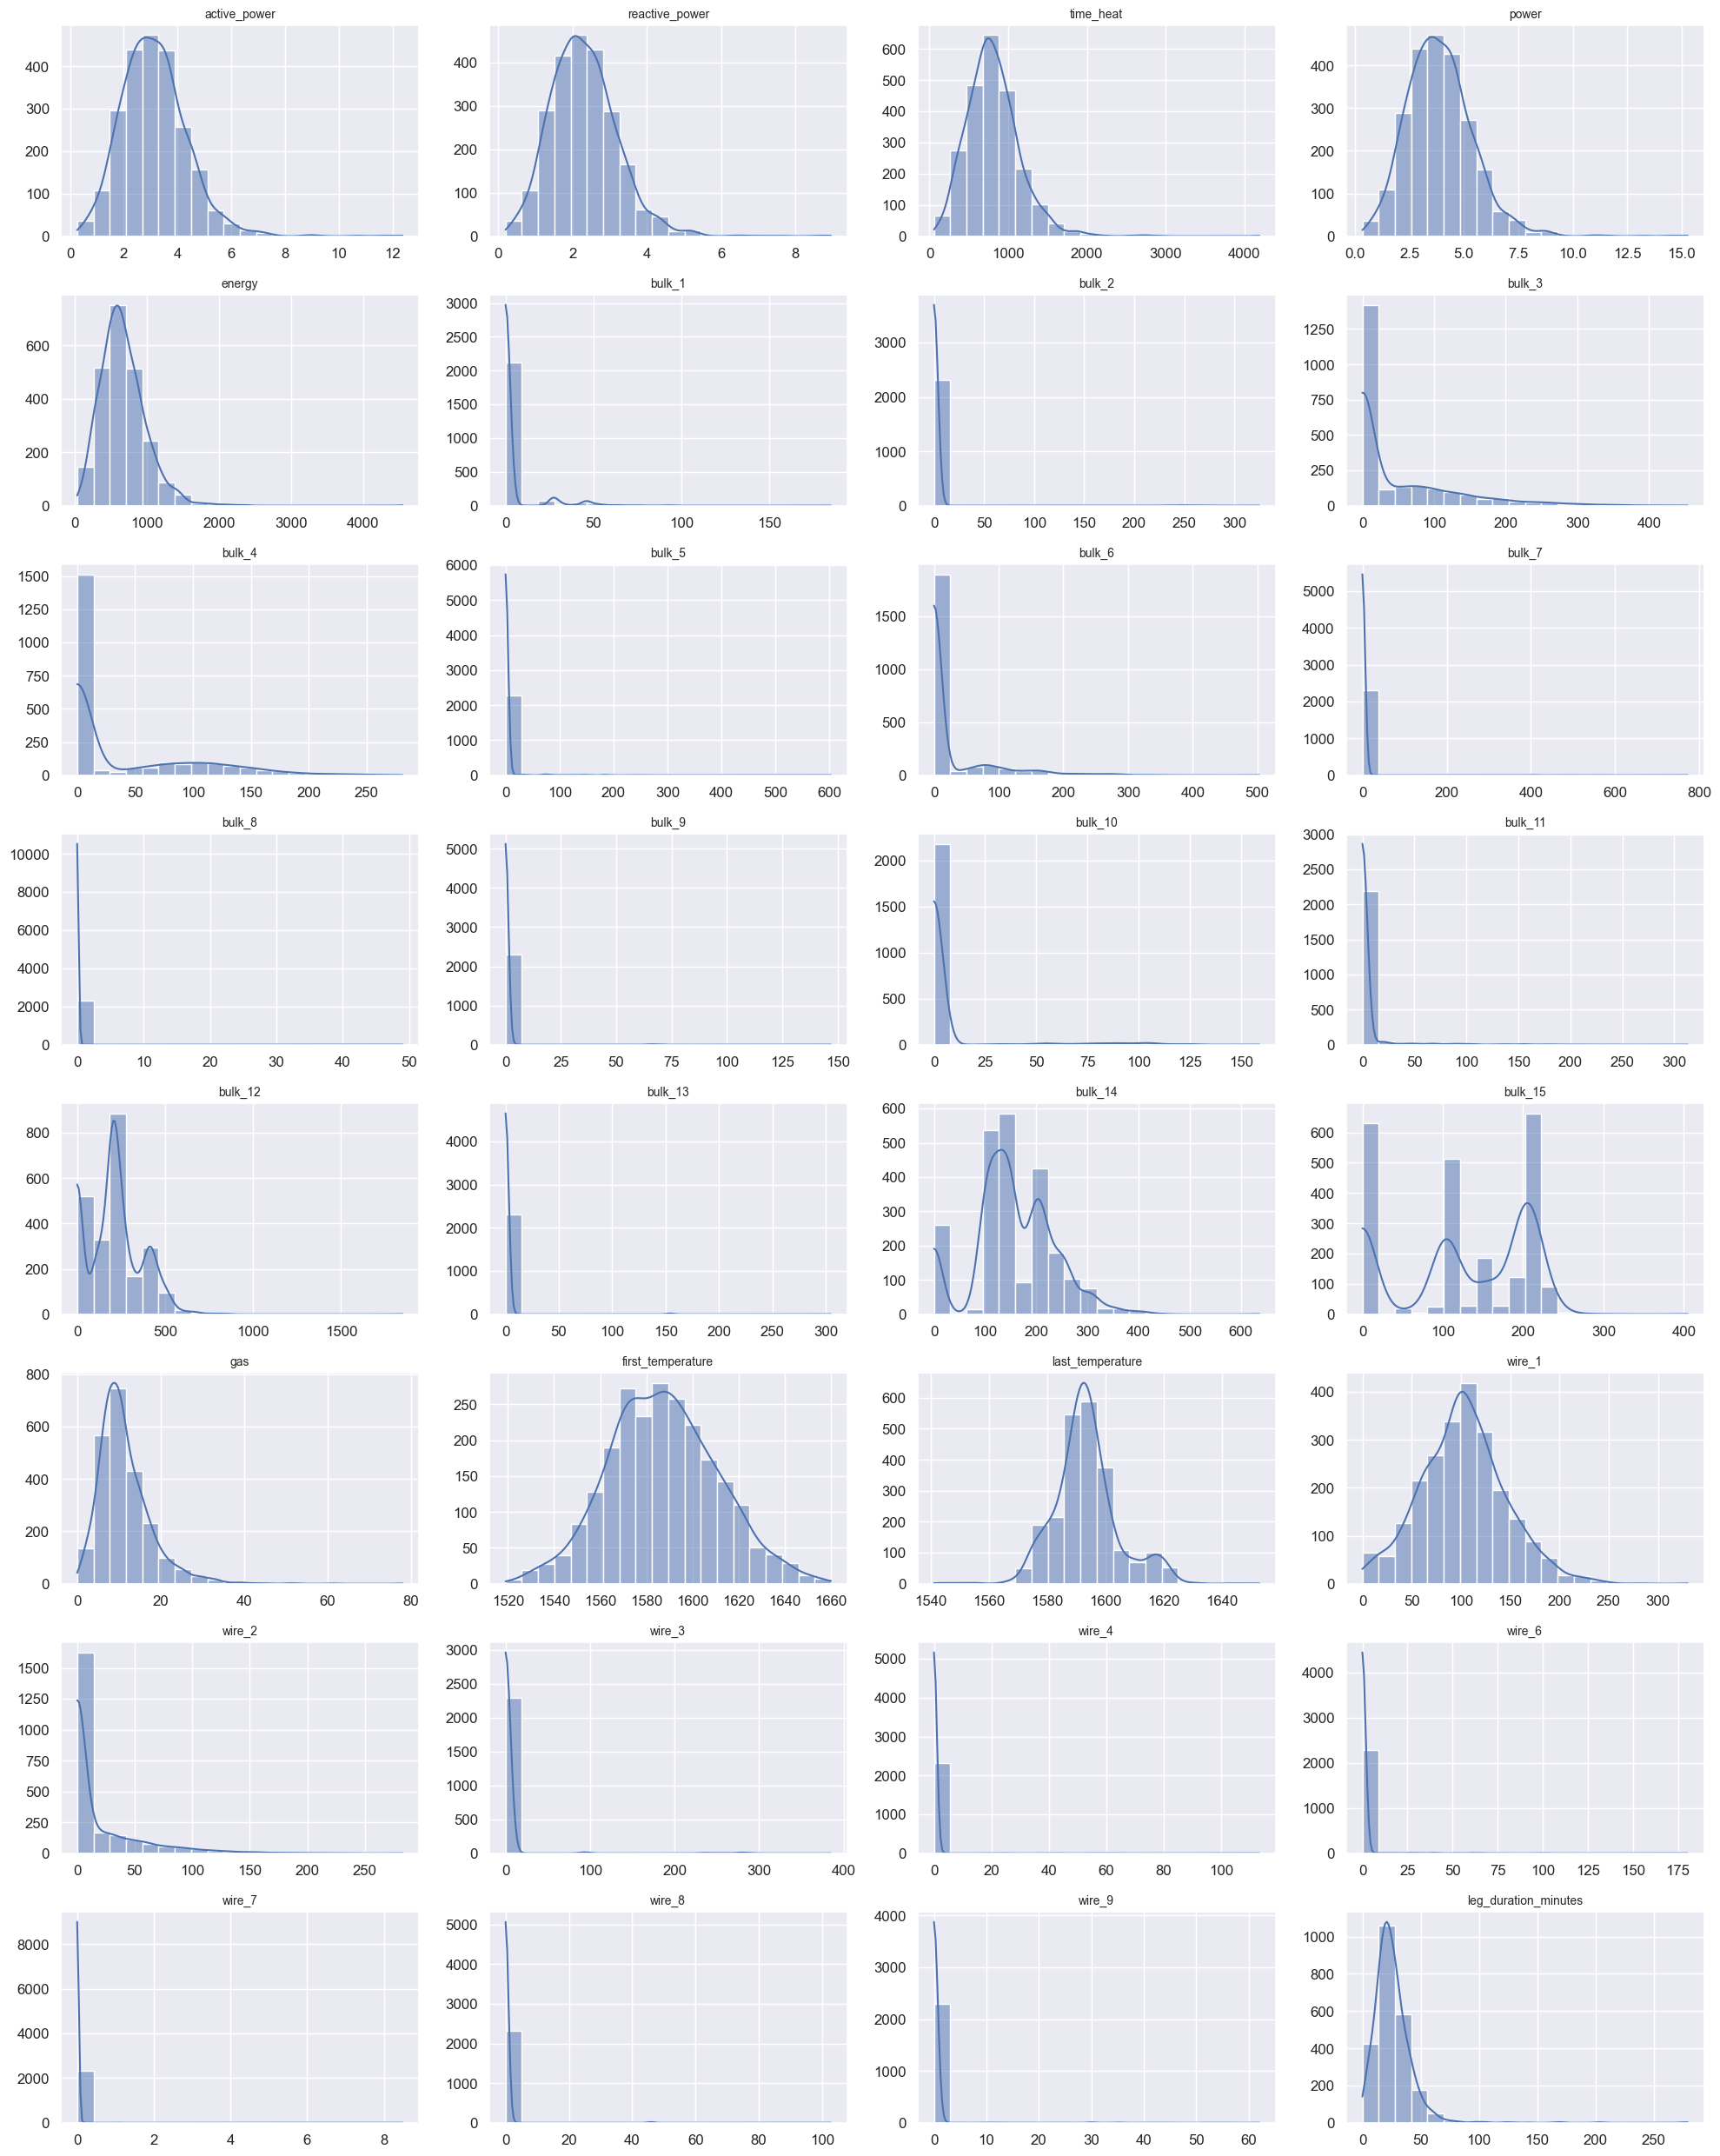

In [92]:
plt.figure(figsize=(20, 25))
for i, column in enumerate(df.columns, 1):
    plt.subplot(8, 4, i)
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'{column}', fontsize=10)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

- `active_power` и `reactive_power`: Распределение нормальное
- `time_heat`:Скошенное вправо распределение с длинным хвостом до 4000+. Значения >2000 редки.
- `power`: Нормальное распределение с пиком около 2.5–5 кВт.
- `energy`: Скошенное вправо распределение с пиком около 500–1000 кВт·ч

- `bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_13`: Пики практически полностью на 0, с редкими выбросами.
- `bulk_12, bulk_14, bulk_15`: Эти материалы ключевые для процесса, добавляются регулярно, но с небольшим разбросом значений.

- `gas`: Распределение скошенное вправо с пиком около 15 единиц. Значения >30 редки. Газ используется в основном в небольших объёмах, но есть партии с высоким расходом.

- `first_temperature` и `last_temperature`: Нормальное распределение. Начальная температура стабильна. Конечная температура выше начальной, что соответствует процессу нагрева, и также стабильна.

- `wire_1`: Нормальное распределение с пиком около 100 единиц. Это основной проволочный материал, регулярно добавляемый в значительных объёмах.
- `wire_2`: Пик на 0 с небольшими выбросами. Используется редко, в минимальных количествах.
- `wire_3–wire_9`: Пики полностью на 0. Эти материалы почти не используются.

### Корреляционный анализ

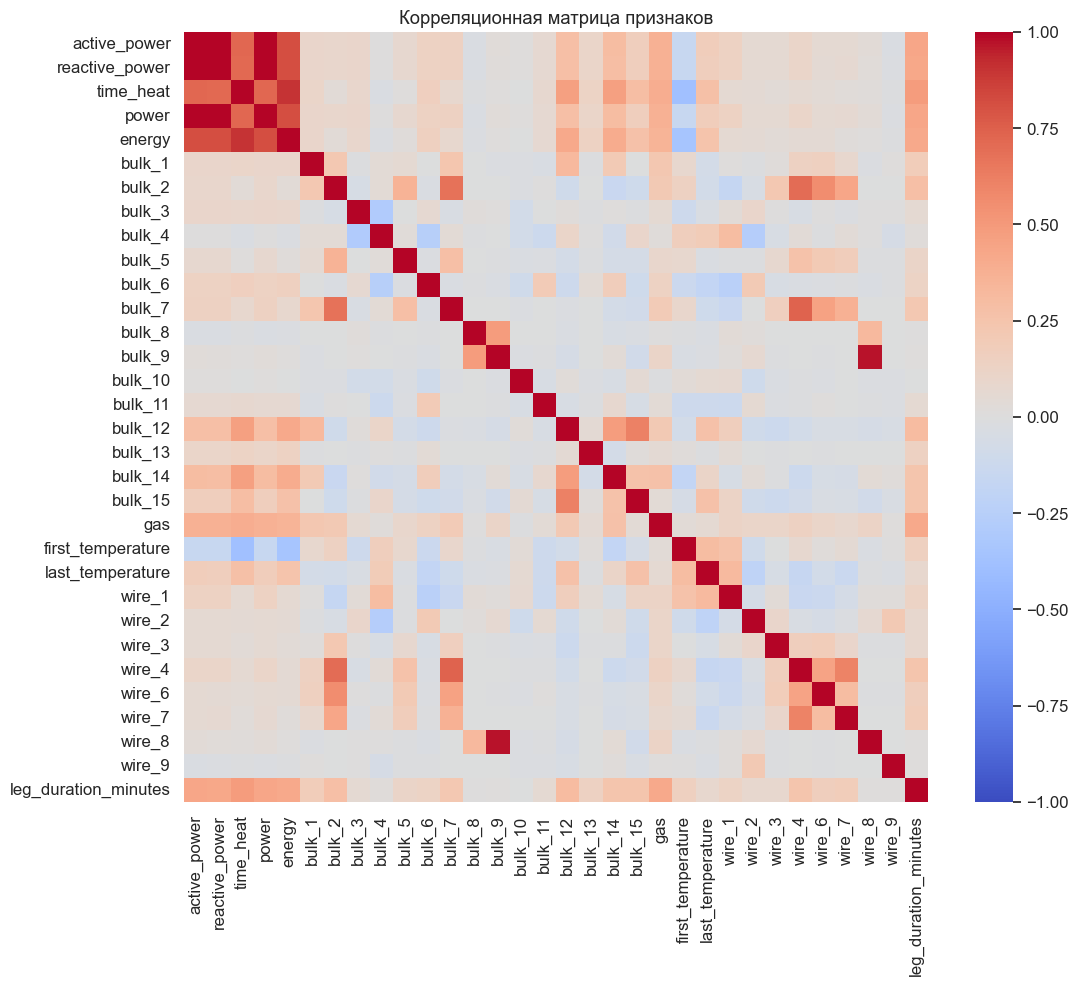

Корреляции с 'last_temperature':
last_temperature        1.000000
wire_1                  0.317488
first_temperature       0.301882
time_heat               0.277953
bulk_12                 0.266805
bulk_15                 0.265772
energy                  0.255918
bulk_4                  0.187817
active_power            0.176486
power                   0.174833
reactive_power          0.171078
bulk_14                 0.114893
leg_duration_minutes    0.080373
bulk_10                 0.061227
gas                     0.059079
wire_8                 -0.010818
bulk_13                -0.010974
bulk_9                 -0.016130
bulk_8                 -0.026613
wire_9                 -0.027561
bulk_5                 -0.028446
bulk_3                 -0.037156
wire_3                 -0.047636
bulk_1                 -0.075428
bulk_2                 -0.082543
wire_6                 -0.084149
bulk_7                 -0.107371
bulk_11                -0.114936
wire_7                 -0.137349
wire_4    

In [93]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Корреляционная матрица признаков")
plt.show()

print("Корреляции с 'last_temperature':")
print(corr_matrix['last_temperature'].sort_values(ascending=False))

print("\nПары признаков с сильной корреляцией (|r| > 0.9):")
strong_corrs = np.where(np.abs(corr_matrix) > 0.9)
strong_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                for x, y in zip(*strong_corrs) if x < y]
for pair in strong_pairs:
    print(f"{pair[0]} — {pair[1]}: {pair[2]:.3f}")

Наблюдается высокая линейная зависимость между признаками `active_power`, `reactive_power`, `time_heat`, `power`, и `energy`. Все они взаимосвязаны и взаимозаменяемы с физической точки зрения. Опираясь на величину коэффициента корреляции между целевым признаком и перечисленным, оставим оставим `power` и `energy`.
Пара bulk_9 — wire_8 с корреляцией 0.975 говорит о практически линейной зависимости между этими признаками. Это может быть связано с технологическим процессом: например, подача сыпучего материала 9 и проволочного материала 8 происходит одновременно или в строгой пропорции. В модель лучше оставить только один из них.

У большинства признаков наблюдается отрицательная корреляция. Это может указывать на то, что увеличение их значений связано с уменьшением температуры.



In [94]:
df = df.drop(['active_power', 'reactive_power', 'time_heat', 'bulk_9'], axis=1)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   power                 2324 non-null   float64
 1   energy                2324 non-null   float64
 2   bulk_1                2324 non-null   float64
 3   bulk_2                2324 non-null   float64
 4   bulk_3                2324 non-null   float64
 5   bulk_4                2324 non-null   float64
 6   bulk_5                2324 non-null   float64
 7   bulk_6                2324 non-null   float64
 8   bulk_7                2324 non-null   float64
 9   bulk_8                2324 non-null   float64
 10  bulk_10               2324 non-null   float64
 11  bulk_11               2324 non-null   float64
 12  bulk_12               2324 non-null   float64
 13  bulk_13               2324 non-null   float64
 14  bulk_14               2324 non-null   float64
 15  bulk_15              

### Подготовка данных для обучения

In [96]:
X = df.drop('last_temperature', axis=1)
y = df['last_temperature']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (1743, 27)
Размер тестовой выборки: (581, 27)


Масштабирование признаков и целевой переменной для нейронной сети.

In [98]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

## Обучение моделей

Рассмотрим три класса моделей:
- Случайный лес.
- Градиентный бустинг.
- Нейронная сеть.

Оценим качество с помощью MAE на кросс-валидации.

### RandomForestRegressor

In [99]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None]
}
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

model_rf = grid_search_rf.best_estimator_
best_rf_mae = -grid_search_rf.best_score_
print(f"Лучшее значение MAE: {best_rf_mae:.2f}")
print(f"Лучшие параметры: {grid_search_rf.best_params_}")

Лучшее значение MAE: 6.52
Лучшие параметры: {'max_depth': 20, 'n_estimators': 300}


In [100]:
best_rf_mae

6.523067299840484

### CatBoostRegressor

In [101]:

param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search_cb = GridSearchCV(
    CatBoostRegressor(random_seed=RANDOM_STATE, verbose=0),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_cb.fit(X_train, y_train)

model_cb = grid_search_cb.best_estimator_
best_cb_mae = -grid_search_cb.best_score_
print(f"Лучшее значение MAE: {best_cb_mae:.2f}")
print(f"Лучшие параметры: {grid_search_cb.best_params_}")

Лучшее значение MAE: 6.24
Лучшие параметры: {'depth': 4, 'iterations': 500, 'learning_rate': 0.05}


### Net

Создаем тензоры

In [102]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

In [103]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Net, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [104]:
def train_and_evaluate(hidden_sizes, learning_rate, epochs=200, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    mae_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
        X_tr = X_train_tensor[train_idx]
        y_tr = y_train_tensor[train_idx]
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]

        model = Net(input_size=X_train_scaled.shape[1], hidden_sizes=hidden_sizes)
        criterion = nn.L1Loss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_tr)
            loss = criterion(outputs.squeeze(), y_tr)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_outputs_unscaled = scaler_y.inverse_transform(val_outputs.squeeze().numpy().reshape(-1, 1)).flatten()
            y_val_unscaled = scaler_y.inverse_transform(y_val.numpy().reshape(-1, 1)).flatten()
            val_mae = np.mean(np.abs(val_outputs_unscaled - y_val_unscaled))
        mae_scores.append(val_mae)

    avg_mae = np.mean(mae_scores)
    return avg_mae

In [105]:
hidden_sizes_options = [(100,), (50, 20), (100, 50)]
learning_rate_options = [0.001, 0.01]

best_mae = float('inf')
best_params = None

for hidden_sizes in hidden_sizes_options:
    for lr in learning_rate_options:
        mae = train_and_evaluate(hidden_sizes, lr, epochs=200)
        print(f"hidden_sizes: {hidden_sizes}, learning_rate: {lr}, MAE: {mae:.2f}")
        if mae < best_mae:
            best_mae = mae
            best_params = {'hidden_sizes': hidden_sizes, 'learning_rate': lr}

print(f"Лучшее значение MAE: {best_mae:.2f}")
print(f"Лучшие параметры: {best_params}")

hidden_sizes: (100,), learning_rate: 0.001, MAE: 6.43
hidden_sizes: (100,), learning_rate: 0.01, MAE: 7.40
hidden_sizes: (50, 20), learning_rate: 0.001, MAE: 6.50
hidden_sizes: (50, 20), learning_rate: 0.01, MAE: 7.20
hidden_sizes: (100, 50), learning_rate: 0.001, MAE: 6.62
hidden_sizes: (100, 50), learning_rate: 0.01, MAE: 7.35
Лучшее значение MAE: 6.43
Лучшие параметры: {'hidden_sizes': (100,), 'learning_rate': 0.001}


In [106]:

results = pd.DataFrame({
    'Модель': ['Random Forest', 'CatBoost', 'PyTorch'],
    'Значение MAE': [best_rf_mae, best_cb_mae, best_mae]
})
results

,Модель,Значение MAE
0,Random Forest,6.523067
1,CatBoost,6.235234
2,PyTorch,6.426015


Лучшей моделью на тренировочной выборке стала CatBoostRegressor, проверим ее на тесте.

##  Протестируем нашу модель

In [107]:
best_model = model_cb
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {test_mae:.2f}")

MAE на тестовой выборке: 6.52


### Проверим модель на адекватность

In [108]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
y_pred_dummy_mean = dummy_mean.predict(X_test)
dummy_mean_mae = mean_absolute_error(y_test, y_pred_dummy_mean)

print(f"MAE константной модели (mean): {dummy_mean_mae:.2f}")

MAE константной модели (mean): 8.24


MAE = 8.24 — значительно выше, чем у CatBoost. Это подтверждает адекватность модели.

### анализ важности признаков.

In [109]:
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importance
}).sort_values(by='Важность', ascending=False)
print("Важность признаков:")
print(importance_df)

Важность признаков:
                 Признак   Важность
17     first_temperature  23.376310
1                 energy  22.793903
26  leg_duration_minutes   6.437055
18                wire_1   6.016206
15               bulk_15   5.230281
7                 bulk_6   4.997149
19                wire_2   4.926402
14               bulk_14   4.690478
0                  power   4.563695
12               bulk_12   3.719420
16                   gas   3.509433
2                 bulk_1   2.769903
5                 bulk_4   1.742284
21                wire_4   1.285581
11               bulk_11   0.946059
10               bulk_10   0.832112
4                 bulk_3   0.738673
20                wire_3   0.431325
8                 bulk_7   0.361826
23                wire_7   0.236973
22                wire_6   0.196376
13               bulk_13   0.087625
6                 bulk_5   0.070516
3                 bulk_2   0.035347
24                wire_8   0.004908
25                wire_9   0.000161
9       

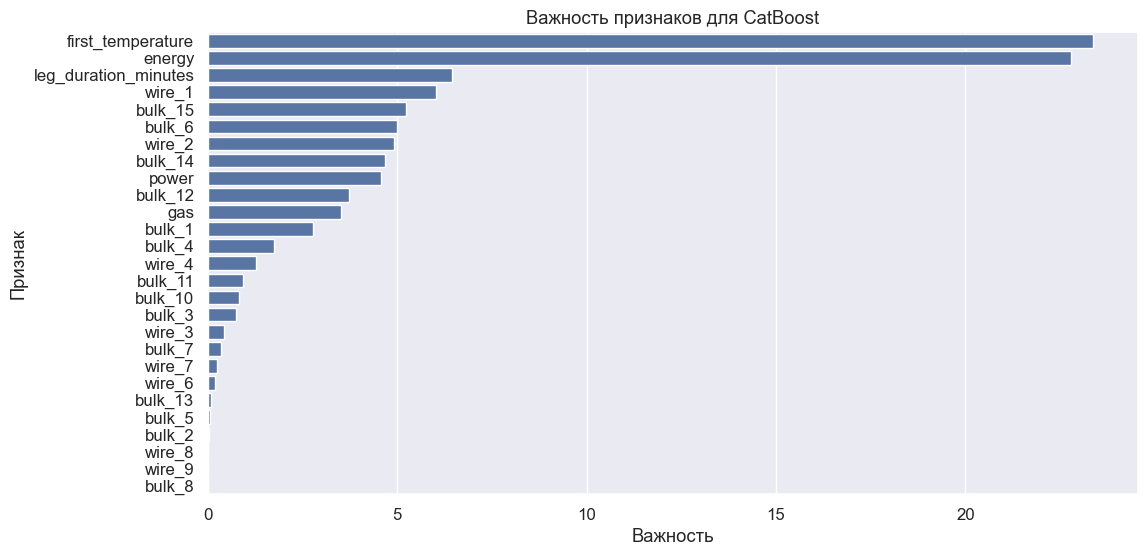

In [110]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Важность', y='Признак', data=importance_df)
plt.title('Важность признаков для CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

- first_temperature и energy — два главных фактора, что логично для металлургического процесса.
- wire_1, bulk_15, bulk_6, wire_2, bulk_14, bulk_12 — ключевые добавки, влияющие на температуру.
- leg_duration_minutes подтверждает, что время легирования имеет значение.
- Признаки вроде bulk_8, wire_9 почти не влияют (важность ~0), что может быть связано с их редким использованием.

Поскольку first_temperature — самый важный признак, давайте построим график зависимости между ним и last_temperature.

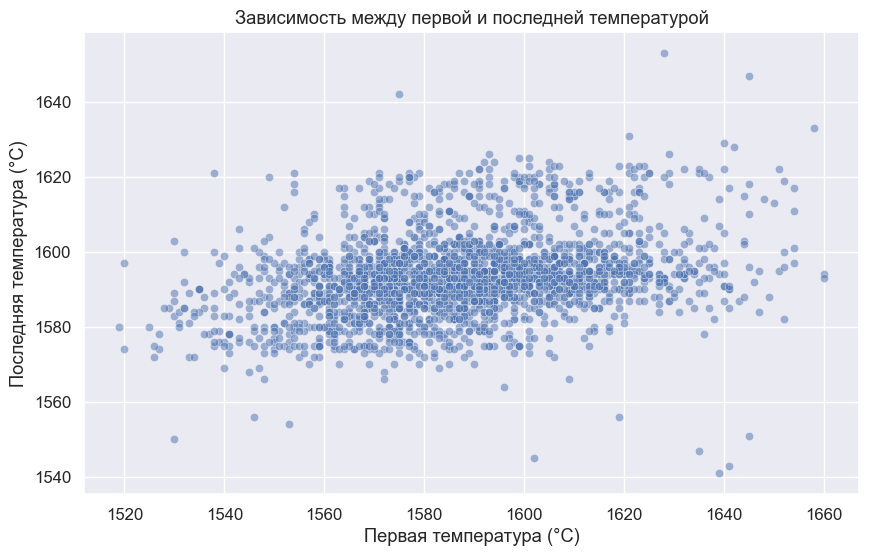

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['first_temperature'], y=df['last_temperature'], alpha=0.5)
plt.title('Зависимость между первой и последней температурой')
plt.xlabel('Первая температура (°C)')
plt.ylabel('Последняя температура (°C)')
plt.grid(True)
plt.show()

Виден положительный наклон: точки распределены вдоль диагонали, что указывает на положительную корреляцию между first_temperature и last_temperature. Чем выше начальная температура, тем выше, в среднем, конечная температура. Есть значительный разброс точек вокруг диагонали, особенно в диапазоне 1550–1600°C для обеих температур. Это говорит о том, что first_temperature не единственный фактор, влияющий на last_temperature. Другие признаки (например, energy, wire_1, bulk_15, leg_duration_minutes) также вносят вклад, что подтверждает их важность.

In [112]:
correlation = df['first_temperature'].corr(df['last_temperature'])
print(f"Корреляция между first_temperature и last_temperature: {correlation:.3f}")

Корреляция между first_temperature и last_temperature: 0.302


Умеренная положительная корреляция. Это подтверждает, что first_temperature влияет на last_temperature, но не объясняет всё изменение (что видно по разбросу на графике).
Разброс объясняется другими признаками, которые модель использует для корректировки предсказаний.

## Вывод

В рамках данного проекта была разработана модель для предсказания температуры сплава на металлургическом комбинате «Стальная птица» с целью оптимизации производственных расходов, связанных с потреблением электроэнергии на этапе обработки стали. Работа включала несколько ключевых этапов: загрузка, исследовательский анализ и предобработка данных, выбор и обучение моделей, а также анализ важности признаков.

1. Анализ и подготовка данных
На начальном этапе были изучены данные, включающие таблицы с информацией о нагреве (data_arc), сыпучих и проволочных материалах (data_bulk, data_bulk_time, data_wire, data_wire_time), продувке газом (data_gas), и замерах температуры (data_temp). Был проведён исследовательский анализ, показавший отсутствие дубликатов и наличие значительных пропусков в сыпучих и проволочных материалах, так же были выявлены аномалии, такие как отрицательная реактивная мощность, которые были обработаны. Данные были объединены по ключу партии (key), обеспечив каждому наблюдению соответствие одной партии. Были созданы новые признаки, такие как длительность нагрева (time_heat), энергия (energy), мощность (power), и длительность этапа легирования (leg_duration_minutes), что позволило лучше отразить технологический процесс. Корреляционный анализ показал умеренную связь first_temperature (0.302) и wire_1 (0.317) с целевой переменной last_temperature, а также мультиколлинеарность между active_power, reactive_power и power, что было учтено при исключении лишних признаков.

2. Разработка и выбор модели
Для предсказания last_temperature были рассмотрены три класса моделей: случайный лес, градиентный бустинг, и нейронная сеть. Данные были разделены на тренировочную (75%) и тестовую (25%) выборки. Для каждой модели проводилась кросс-валидация (5 фолдов) с метрикой MAE, чтобы выбрать лучшую. Random Forest показал MAE 6.52, CatBoost — 6.23, а PyTorch — 6.43 на кросс-валидации. CatBoost оказался наиболее точным, и для него была произведена финальная оценка на тестовой выборке, где MAE составил 6.52. Проверка адекватности с использованием DummyRegressor (среднее значение) дала MAE 8.24, что подтверждает значительное превосходство CatBoost над константной моделью.

3. Анализ важности признаков
С помощью CatBoost были определены ключевые признаки, влияющие на last_temperature. Самые важные: first_temperature (23.38), energy (22.79), и leg_duration_minutes (6.44). Другие значимые признаки включают wire_1 (6.02), bulk_15 (5.23), bulk_6 (5.00), wire_2 (4.93), bulk_14 (4.69), power (4.56), и bulk_12 (3.72). Менее важные признаки, такие как bulk_8 и wire_9, имеют близкую к нулю важность.

4. Дополнительное исследование
Для first_temperature — самого важного признака — был построен график зависимости с last_temperature. График показал умеренную положительную корреляцию (0.302), с плотной концентрацией точек в диапазоне 1560–1620°C, но с заметным разбросом, что подтверждает влияние других факторов, таких как энергия и материалы. Это объясняет высокую важность first_temperature в модели и подчёркивает необходимость учитывать дополнительные параметры для точного предсказания.

5. Итоговые рекомендации
Оптимизация энергозатраты: Увеличение energy может повысить last_temperature, но следует контролировать leg_duration_minutes, чтобы минимизировать избыточное потребление электроэнергии. Стабилизация first_temperature в диапазоне 1560–1620°C может снизить разброс и упростить достижение целевой температуры.
Выбор материалов: Обращать особое внимание на wire_1, bulk_15, bulk_6, wire_2, bulk_14, и bulk_12, изучая их химическое и тепловое воздействие на сплав.

6. Заключение
Проект успешно достиг поставленной цели: разработана модель, способная предсказывать температуру сплава с точностью, превышающей константное предсказание. CatBoost оказался наиболее эффективным решением, предоставляя надёжный инструмент для имитации технологического процесса и снижения энергозатрат на комбинате «Стальная птица». Полученные результаты и рекомендации могут быть использованы для дальнейшей оптимизации производства, а также для анализа влияния ключевых параметров на качество стали.